# CNN and LRP
All the inspiration for the created code can be found in the front ``README.md``.

## Preparation
For this project we will use PyTorch to create our CNN. For the LRP we will create our own package, specialised for the net we have created.


In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from lrp.lrp import LRPModel
from PIL import Image

In this code we prepare the dataset for training in multiple steps:
* Images are adjusted with transformations (resize, greyscale, normalisation) and then transformed to tensors because the images are very different due to being a large sample of MRIs.
* We choose a large training size (80%) for training but let 20% for training, with the amount of images we have, this should suffice.
* We then split them randomly and give the images labels first for training and later to know if the CNN was right with his prediction.

In [3]:
# Set batch size
batch_size = 32

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize the images
    transforms.Grayscale(num_output_channels=1), # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Load the dataset from the folders
dataset = ImageFolder(root='./brain-tumor-data-set', transform=transform)

# Split the dataset
train_size = int(0.8 * len(dataset)) # 80% for training 
test_size = len(dataset) - train_size  # The rest for testing

# Create subsets
trainset, testset = random_split(dataset, [train_size, test_size])

# Create data loaders
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Define the class names (labels)
classes = ('Brain Tumor', 'Healthy')

Here is visualized a batch of training data with their labels. We do this to check the data quality and label distribution.

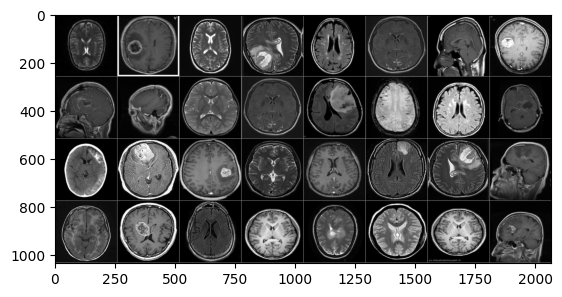

Healthy Brain Tumor Healthy Brain Tumor Healthy Healthy Healthy Brain Tumor Brain Tumor Brain Tumor Healthy Healthy Brain Tumor Healthy Healthy Brain Tumor Healthy Brain Tumor Brain Tumor Healthy Healthy Brain Tumor Brain Tumor Brain Tumor Healthy Brain Tumor Healthy Healthy Brain Tumor Brain Tumor Healthy Brain Tumor


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images and print labels
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Now we can define our CNN. For this we choose two Convolutional Layers (conv1, conv2) and three Fully Connected Layers (fc1, fc2, fc3). The architecture uses ReLU activation functions and is designed to process input images (1 channel, greyscale) and classify them into two classes (Brain Tumour, Healthy).

# ES FEHLT WARUM

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.relu1 = nn.ReLU() 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(20 * 248 * 248, 50)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 2) # 2 Classes (Brain Tumor / Healthy)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

net = Net()

## Training
Dieser Code implementiert den Trainingsprozess über mehrere Epochen. In jeder Epoche werden die Daten batchweise durch das Modell verarbeitet. Der Verlust wird berechnet (criterion), ein Backpropagation-Schritt durchgeführt, und die Modellparameter werden aktualisiert (optimizer.step()). Alle 500 Batches wird der durchschnittliche Verlust ausgegeben, um den Trainingsfortschritt zu überwachen. Nach Abschluss wird die Trainingsphase beendet.

Dieser Code definiert den Trainingsprozess. Die Verlustfunktion ist CrossEntropyLoss, die für Klassifikationsprobleme geeignet ist. Der Optimierer SGD (Stochastic Gradient Descent) aktualisiert die Modellparameter mit einer Lernrate von 0.01 und Momentum von 0.9, um schneller und stabiler zu konvergieren.

In [7]:
num_epochs = 5  # Number of epochs to train
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(num_epochs):  # Loop over the dataset multiple times
    net.train()  # Set the model to training mode
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        # Zero the parameter gradients after each batch
        optimizer.zero_grad()
        
        # Forward pass
        outputs = net(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        if batch_idx % 500 == 499:  # Print every 100 mini-batches
            print(f'Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

We now save our trained CNN parameters in the ``cifar_net.pth'' file so that we can reload the parameters later without having to retrain the model.

In [8]:
PATH = './saved-net/cifar_net.pth'
torch.save(net.state_dict(), PATH)

Here we can load the previously saved model (cifar_net.pth) into the newly created model net.

In [ ]:
PATH = './saved-net/cifar_net.pth'
net.load_state_dict(torch.load(PATH, weights_only=True))

## Verification
This code visualises a batch of test images and outputs the associated ground truth labels. This is used to check which classes are contained in the test data batch and what the images look like so that the model can be validated later.

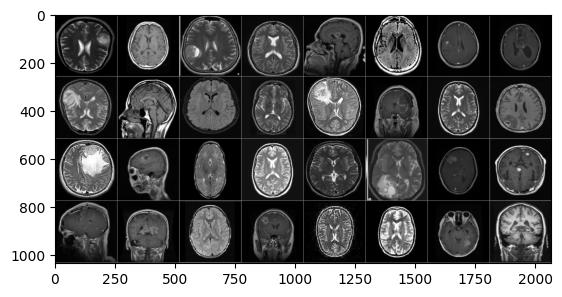

GroundTruth:  Healthy Healthy Brain Tumor Healthy


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Dieser Code führt eine Vorhersage durch, indem er die geladenen Testbilder (images) durch das Modell net schickt. Die Ausgaben (outputs) sind die Rohvorhersagen des Modells, bevor eine Aktivierungsfunktion oder eine Umwandlung wie softmax angewendet wird, um die finalen Klassenwahrscheinlichkeiten zu erhalten.

Dieser Code verwendet torch.max, um die vorhergesagten Klassen für jedes Bild in der Batch zu extrahieren. predicted enthält die Indizes der maximalen Ausgabewerte (die Klassenvorhersagen) aus den outputs. Anschließend werden diese Vorhersagen ausgegeben, wobei die Klassenbezeichner (Brain Tumor oder Healthy) entsprechend den vorhergesagten Indizes angezeigt werden.

In [29]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  Healthy Healthy Healthy Healthy


Here we evaluate the accuracy of the model on the test dataset. During inference, gradient computation is disabled (torch.no_grad()) to reduce memory usage. For each test image, the prediction is made and the number of correct predictions is compared to the number of predicted == labels. Finally, the overall accuracy of the model on the test data is calculated and output.

In [13]:
correct = 0
total = 0
# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = net(images)
        # The class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 95 %


Now we can calculate the accuracy of the model for each individual class. For each test batch, it checks whether the prediction of the model matches the actual class, and the correct predictions for each class are counted. At the end, the exact accuracy for each class is calculated and output to see how well the model performs for each specific class.

In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Brain Tumor is 97.1 %
Accuracy for class: Healthy is 94.2 %


## First observation
We can see that the model is usually more accurate at identifying a brain with a tumor than a healthy brain. This may be due to the fact that the CNN may incorrectly identify healthy parts of the brain as a brain tumor. To show you this, here are two images, one with a brain tumor and one without, guess which one!

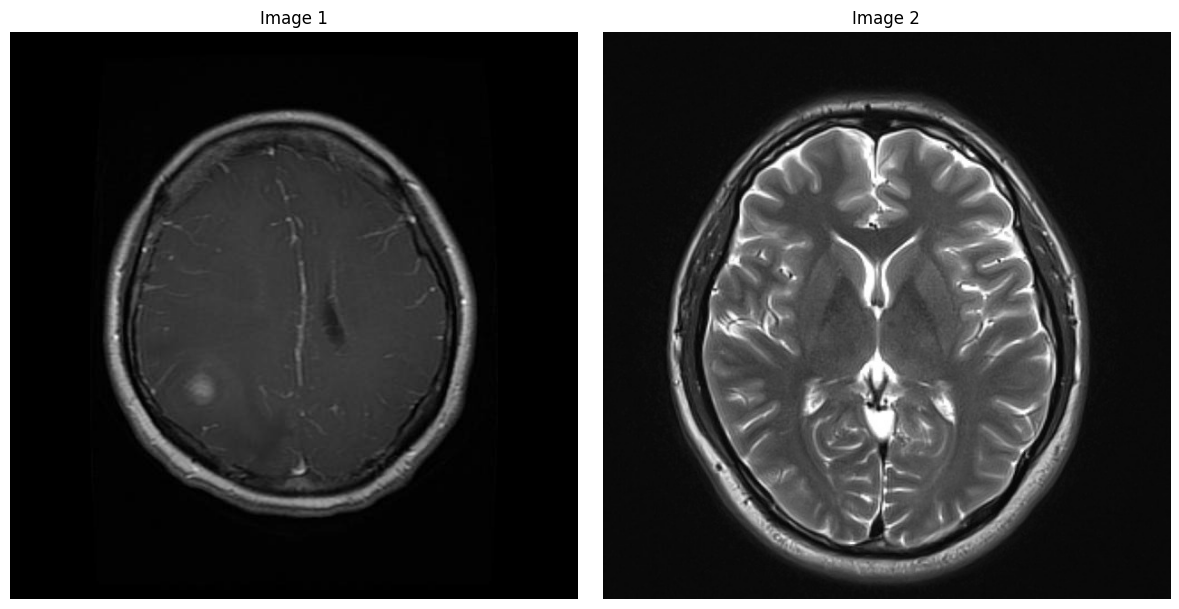

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(Image.open('./images-documentation/hidden_image_1.png'))
axes[0].set_title("Image 1")
axes[0].axis('off')  # Hide axes

axes[1].imshow(Image.open('./images-documentation/hidden_image_2.jpg'))
axes[1].set_title("Image 2")
axes[1].axis('off')  # Hide axes

fig.tight_layout()
plt.show()

## LRP
Dieser Code implementiert die Anwendung von Layer-wise Relevance Propagation (LRP) auf ein Bild, um die wichtigsten Merkmale für die Modellvorhersage zu visualisieren.

    load_LRP: Lädt das trainierte Modell und bereitet es für LRP vor.
    run_LRP: Wendet LRP auf ein Bild an, um die Relevanzkarte zu berechnen. Zuerst wird das Bild mit den notwendigen Transformationen vorbereitet (Grayscale, Resize, Normalisierung) und dann durch das LRP-Modell geführt.
    create_relevance_map: Unnormalisiert das Eingabebild und visualisiert sowohl das Originalbild als auch die berechnete Relevanzkarte. Letztere zeigt, welche Teile des Bildes die Entscheidung des Modells am meisten beeinflusst haben.

Am Ende wird für ein ausgewähltes Bild eine Relevanzkarte erstellt und visualisiert, die den Beitrag jedes Pixels zur Klassifizierung des Bildes anzeigt.

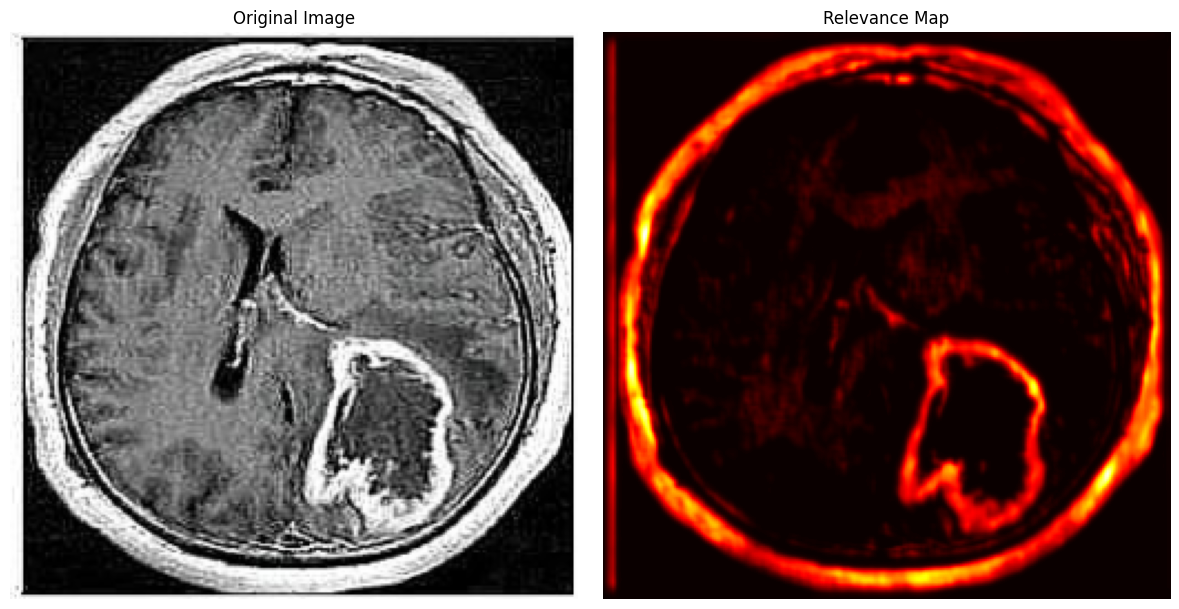

In [22]:
def load_LRP() -> LRPModel:
    net = Net()
    net.load_state_dict(torch.load(PATH, weights_only=True))
    return LRPModel(net)

def run_LRP(lrp_model, image) -> torch.tensor:
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    input_tensor = transform(image).unsqueeze(0)  # Load or preprocess an input image tensor
    return lrp_model.forward(input_tensor)

def create_relevance_map(relevance_map, image) -> None:
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    input_image_np = transform(image).detach().numpy()
    input_image_np = input_image_np.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    input_image_np = (input_image_np * 0.5 + 0.5)  # Unnormalize to [0, 1]

    relevance_map = (relevance_map - relevance_map.min()) / (relevance_map.max() - relevance_map.min())

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(input_image_np)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(relevance_map, cmap='hot')
    axes[1].set_title("Relevance Map")
    axes[1].axis('off')  # Hide axes

    fig.tight_layout()
    plt.show()

image = Image.open('./brain-tumor-data-set/Brain-Tumor/Cancer (2035).jpg')
#image = Image.open('./brain-tumor-data-set/Healthy/Not Cancer  (7).jpg')
lrp_model = load_LRP()
relevance_map = run_LRP(lrp_model, image)
create_relevance_map(relevance_map, image)